# **Cycle 3 Tutorial** - Simulation Based Inference for cosmology

Tutorial largely based on the notebooks and examples available at https://github.com/maho3/ltu-ili developped by Matt Ho et al. in the fraework of the LtU collaboration - Please refer to the repository for more info. We thank the LtU collaboration for making this material available



# Install requirements

In [ ]:
# Upgrade pip
!pip install --upgrade pip

# Install the package from GitHub
!pip install -e git+https://github.com/maho3/ltu-ili#egg=ltu-ili


  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Obtaining ltu-ili from git+https://github.com/maho3/ltu-ili#egg=ltu-ili
  Cloning https://github.com/maho3/ltu-ili to ./src/ltu-ili
  Running command git clone --filter=blob:none --quiet https://github.com/maho3/ltu-ili /content/src/ltu-ili
  Resolved https://github.com/maho3/ltu-ili to commit 3019bbd534424681e91c9cb001d6fe16728dfb72
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/maho3/tarp.git to /tmp/pip-install-rwdzkplu/tarp_6acfa84883bd46cf8f06e15042c4f5fc
  Running command git clone --filter=blob:none --quiet https://github.com/maho3/tarp.git /tmp/pip-install-rwdzkplu/tarp_6acfa84883bd46cf8f06e15042c4f5fc
  Resolved https://github.com/maho3/tarp.git to commit 3fc2bfd0280b6239f8e367b7789fb4df8a907e33
  Preparing m

In [ ]:
import sys
import site
import os

# Get the site-packages directory where packages are installed
site_packages_path = site.getsitepackages()

# Add the path to the sys.path
sys.path.append(os.path.join('/content/src/', 'ltu-ili'))  # Assuming 'ltu_ili' is the folder name

import ili



In [ ]:
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn

from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


# Toy Example with simulated data (NPE)
In this section we are going to generate some data dependent on 3 parameters (our theta space) and use these toy simulation to illustrate the SBI process and validation

In [ ]:
# create synthetic catalog
def simulator(params):
    # create toy simulations
    x = np.arange(10)
    y = 3 * params[0] * np.sin(x) + params[1] * x ** 2 - 2 * params[2] * x
    y += np.random.randn(len(x))
    return y

seed_sim = 12345
np.random.seed(seed_sim)
theta = np.random.rand(200, 3)  # 200 simulations, 3 parameters
x = np.array([simulator(t) for t in theta])

# make a dataloader
loader = NumpyLoader(x=x, theta=theta)

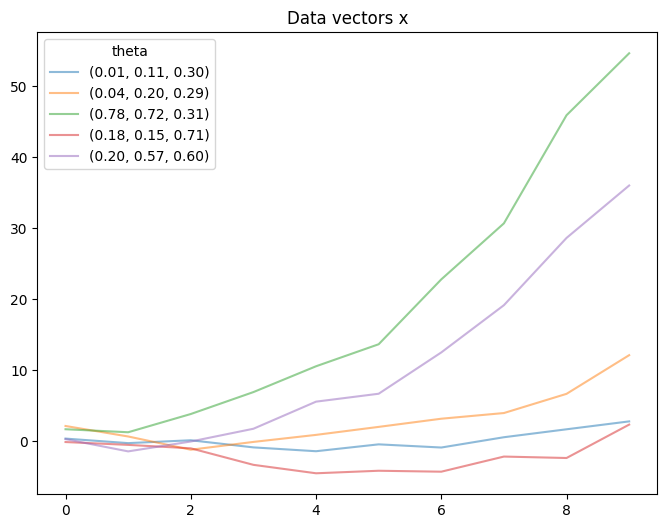

In [ ]:
# plot some examples of the data
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(5):
    ind = np.random.randint(len(theta))
    ax.plot(x[ind], alpha=0.5, label=f'(%.2f, %.2f, %.2f)' % tuple(theta[ind]))
ax.legend(title='theta')
ax.set_title('Data vectors x')
plt.show()

The following cell is the main configuration setup for the package. We define the prior distribution, the type of inference (NPE, NLE) and the NN model. We can define multiple NN architectures into a list that will be fitted sequentially.

In [ ]:
# define a prior
prior = ili.utils.Uniform(low=[0, 0, 0], high=[1, 1, 1], device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=50, num_transforms=5),
    ili.utils.load_nde_sbi(engine='NPE', model='mdn', hidden_features=50, num_components=6)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=None,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [ ]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

 Neural network successfully converged after 306 epochs.

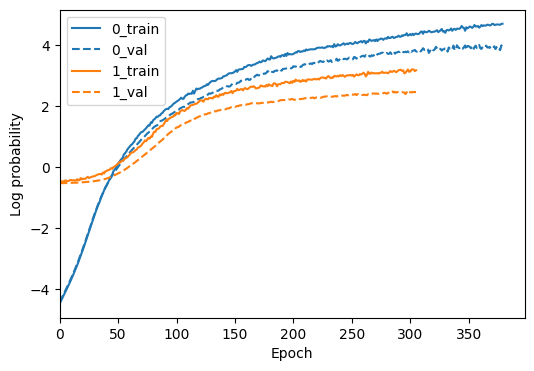

In [ ]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

We can now sample the posterior distributions from the ensemble of all networks trained

In [ ]:
# choose a random input
seed_in = 49
np.random.seed(seed_in)
ind = np.random.randint(len(theta))

# generate samples from the posterior using accept/reject sampling
seed_samp = 32
torch.manual_seed(seed_samp)
samples = posterior_ensemble.sample((1000,), torch.Tensor(x[ind]).to(device))

# calculate the log_prob for each sample
log_prob = posterior_ensemble.log_prob(samples, torch.Tensor(x[ind]).to(device))

samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

Drawing 844 posterior samples:   0%|          | 0/844 [00:00<?, ?it/s]

Drawing 156 posterior samples:   0%|          | 0/156 [00:00<?, ?it/s]

Example of posterior samples for a given input. The true value is indicated with a red cross.

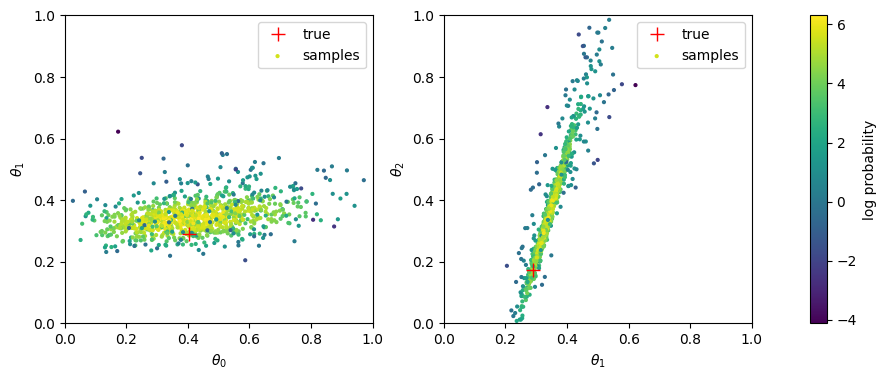

In [ ]:
# plot the posterior samples and the true value
fig, axs = plt.subplots(1, 3, figsize=(10,4), gridspec_kw={'width_ratios': [1,1,0.05]})
for i in range(2):
    axs[i].plot(theta[ind,i], theta[ind,i+1], 'r+', markersize=10, label='true')
    im = axs[i].scatter(samples[:,i], samples[:,i+1], c=log_prob, s=4, label='samples')
    axs[i].set_aspect('equal')
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(0,1)
    axs[i].set_xlabel(f'$\\theta_{i}$')
    axs[i].set_ylabel(f'$\\theta_{i+1}$')
    axs[i].legend()
plt.colorbar(im, label='log probability', use_gridspec=True, cax=axs[2])

Drawing 826 posterior samples:   0%|          | 0/826 [00:00<?, ?it/s]

Drawing 174 posterior samples:   0%|          | 0/174 [00:00<?, ?it/s]

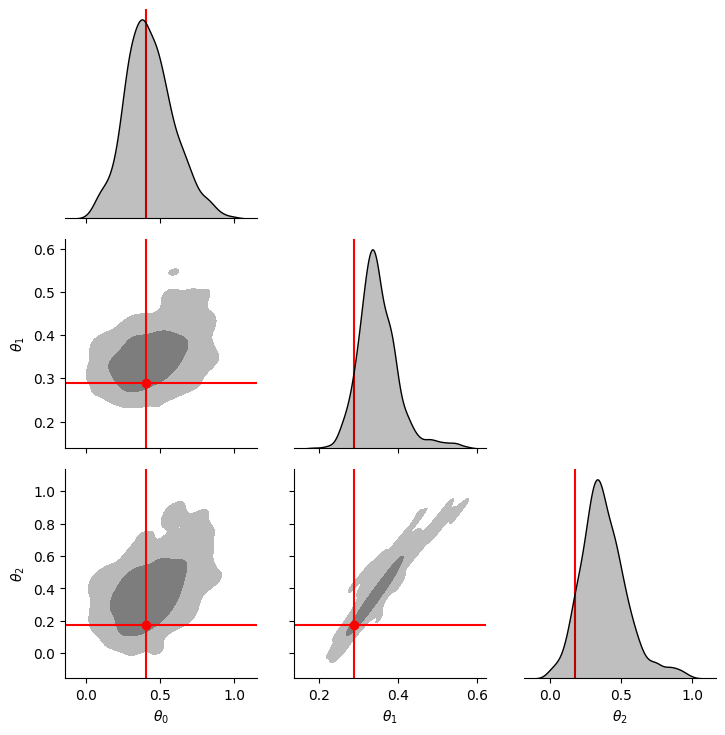

In [ ]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    labels=[f'$\\theta_{i}$' for i in range(3)]
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x[ind], theta_fid=theta[ind],
    plot_kws=dict(fill=True)
)

Validation metrics

100%|██████████| 100/100 [00:02<00:00, 37.79it/s]


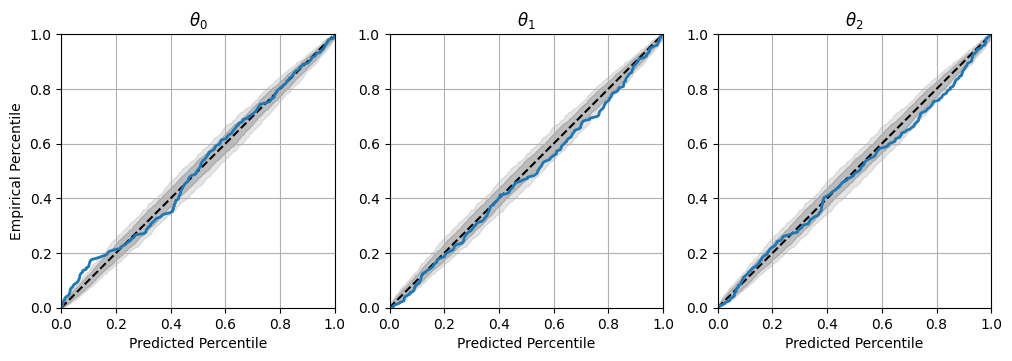

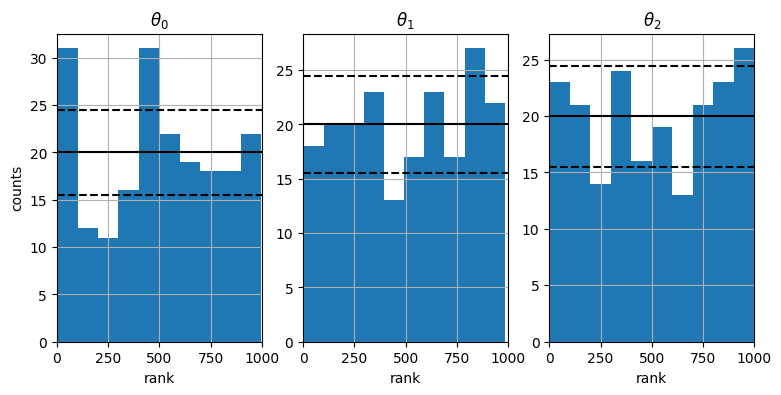

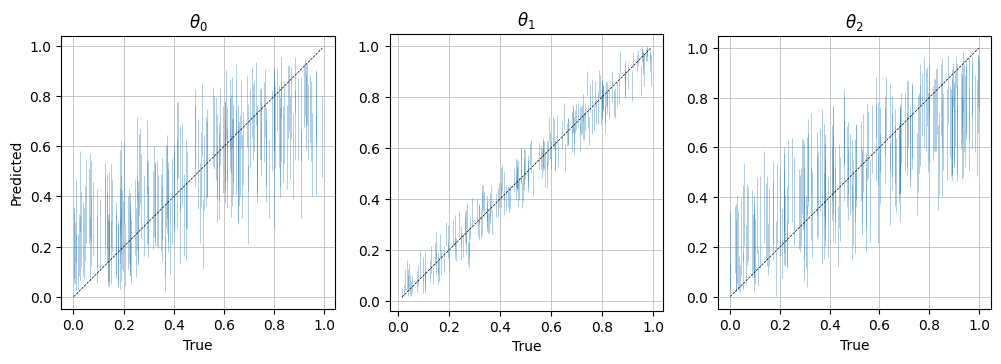

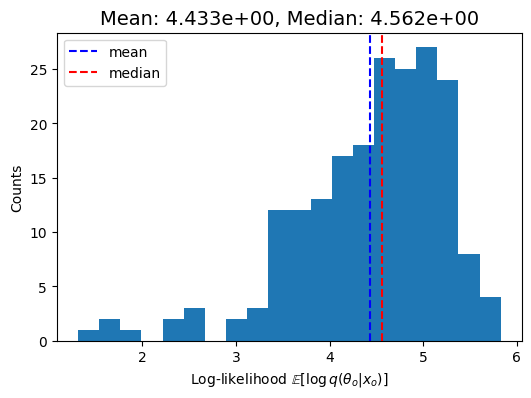

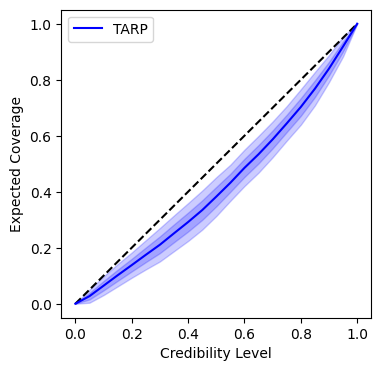

In [ ]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct',
    labels=[f'$\\theta_{i}$' for i in range(3)],
    plot_list = ["coverage", "histogram", "predictions", "tarp", "logprob"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=x, theta=theta
)

We can also explore the different NN models independently (instead of the ensemble posterior)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

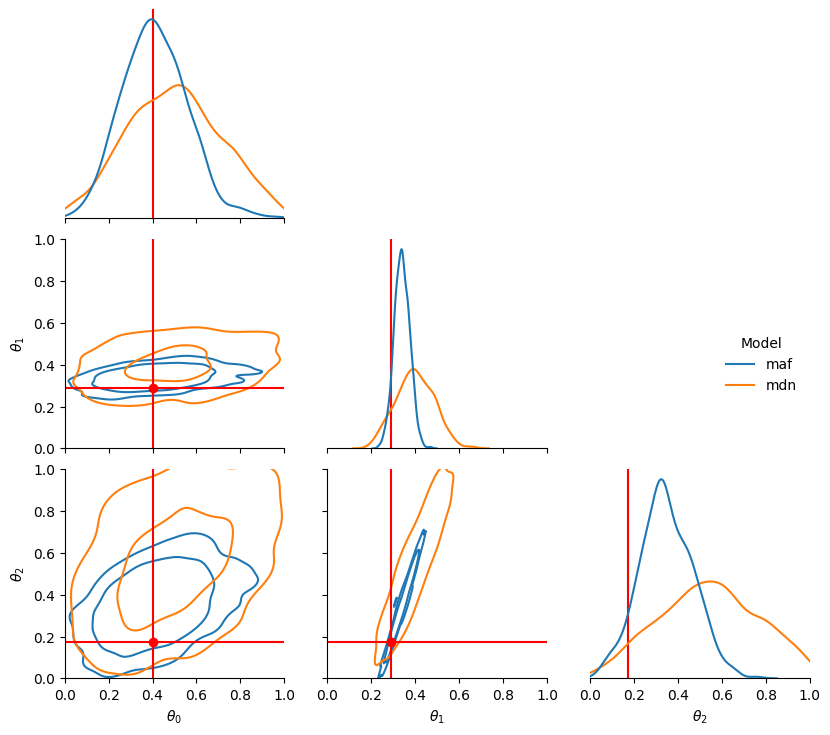

In [ ]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    labels=[f'$\\theta_{i}$' for i in range(3)]
)

# plot the posterior for model #1 (MAF)
fig = metric(
    posterior=posterior_ensemble.posteriors[0],
    x_obs = x[ind], theta_fid=theta[ind],
    name='maf',
    lower=np.zeros(3), upper=np.ones(3)
)
# overplot the posterior for model #2 (MDN)
fig = metric(
    posterior=posterior_ensemble.posteriors[1],
    x_obs = x[ind], theta_fid=theta[ind],
    name='mdn',
    lower=np.zeros(3), upper=np.ones(3),
    grid=fig  # overplot on the same figure
)

100%|██████████| 100/100 [00:02<00:00, 49.18it/s]


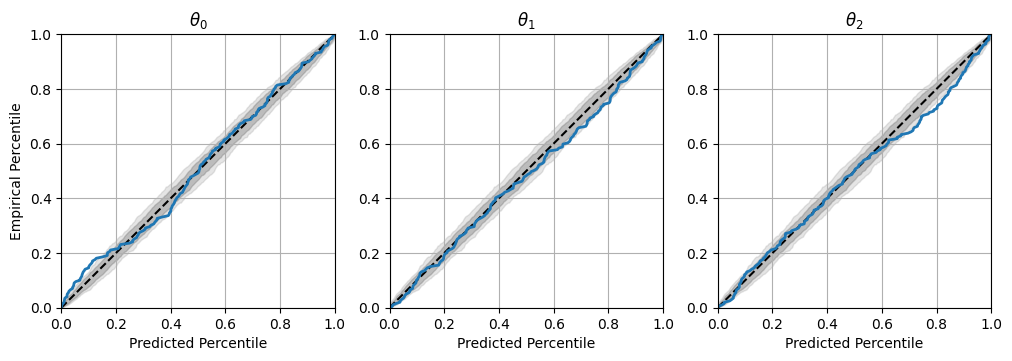

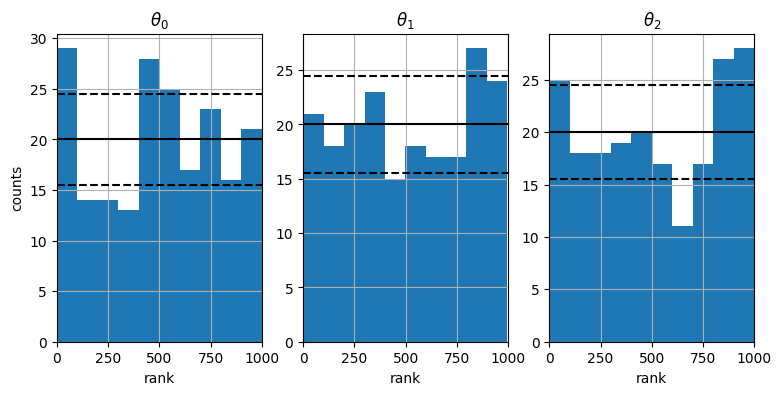

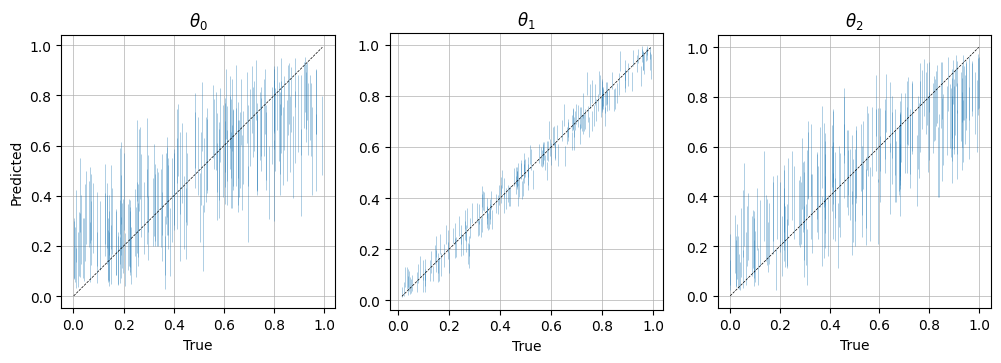

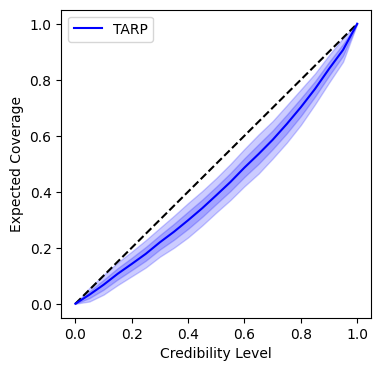

In [ ]:
# Drawing samples for each posterior in the ensemble
# First the MAF posterior
metric = PosteriorCoverage(num_samples=1000,
    sample_method='direct', labels=[f'$\\theta_{i}$' for i in range(3)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"])

fig = metric(
    posterior=posterior_ensemble.posteriors[0],
    x=x, theta=theta
)

# Toy Example with Simulated Data (NLE)

In [ ]:
# create the same synthetic catalog as the previous example
def simulator(params):
    # create toy simulations
    x = np.arange(10)
    y = 3 * params[0] * np.sin(x) + params[1] * x ** 2 - 2 * params[2] * x
    y += np.random.randn(len(x))
    return y

seed_sim = 4321
np.random.seed(seed_sim)
theta = np.random.rand(200, 3)  # 200 simulations, 3 parameters
x = np.array([simulator(t) for t in theta])

# make a dataloader
loader = NumpyLoader(x=x, theta=theta)

We now set the type of infernece to NLE

In [ ]:
# define a prior
prior = ili.utils.Uniform(low=[0, 0, 0], high=[1, 1, 1], device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NLE', model='maf', hidden_features=50, num_transforms=5),
    ili.utils.load_nde_sbi(engine='NLE', model='made', hidden_features=50, num_transforms=5),
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 5e-5
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NLE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=None,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [ ]:

# train the model. this outputs a posterior model and training logs
posterior_ensemble, summaries = runner(loader=loader)

 Neural network successfully converged after 204 epochs.

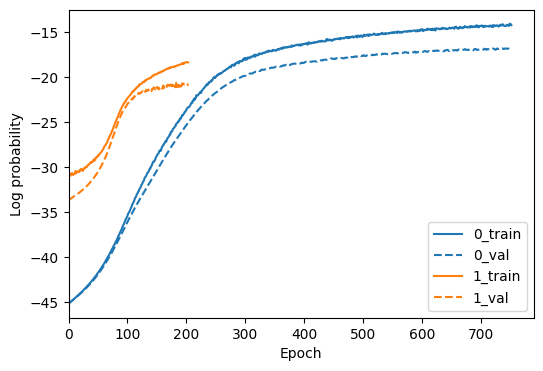

In [ ]:
# plot train/validation loss
f, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

Because it is NLE, sampling the posterior requires a sampling algorithm such as MCMC or similar

In [ ]:
# choose a random input
seed_ind = 24
np.random.seed(seed_ind)
ind = np.random.randint(len(theta))

# generate samples from the posterior using MCMC
samples = posterior_ensemble.sample(
    (1000,), x[ind],
    method='slice_np_vectorized', num_chains=6
).detach().cpu().numpy()

# calculate the potential (prop. to log_prob) for each sample
log_prob = posterior_ensemble.log_prob(
    samples,
    x[ind]
).detach().cpu().numpy()

Running vectorized MCMC with 6 chains:   0%|          | 0/10404 [00:00<?, ?it/s]

Running vectorized MCMC with 6 chains:   0%|          | 0/804 [00:00<?, ?it/s]

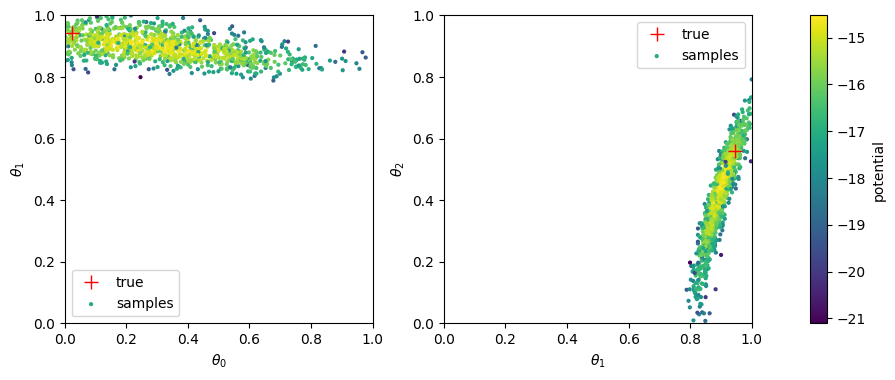

In [ ]:
# plot the posterior samples and the true value
f, axs = plt.subplots(1, 3, figsize=(10,4), gridspec_kw={'width_ratios': [1,1,0.05]})
for i in range(2):
    axs[i].plot(theta[ind,i], theta[ind,i+1], 'r+', markersize=10, label='true')
    im = axs[i].scatter(samples[:,i], samples[:,i+1], c=log_prob, s=4, label='samples')
    axs[i].set_aspect('equal')
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(0,1)
    axs[i].set_xlabel(f'$\\theta_{i}$')
    axs[i].set_ylabel(f'$\\theta_{i+1}$')
    axs[i].legend()
plt.colorbar(im, label='potential', use_gridspec=True, cax=axs[2])

In [ ]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PosteriorCoverage(
    num_samples=1000, sample_method='vi',
    sample_params={'dist': 'maf', 'n_particles': 32, 'learning_rate': 1e-2},
    labels=[f'$\\theta_{i}$' for i in range(3)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"]
)

# Drawing samples from the ensemble posterior
fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=x, theta=theta
)

  4%|▎         | 7/200 [01:02<28:41,  8.92s/it]


KeyboardInterrupt: 

# Cosmological inference with CAMELS

In [ ]:
!pip install gdown

In [ ]:
#@title Download data by running this cell

# https://drive.google.com/file/d/15WCEscE3lv36jPVOSZdWBwPvA-19b1TS/view?usp=drive_link
import gdown
import os

# Create the directory if it doesn't exist
os.makedirs('./toy', exist_ok=True)

# Google Drive file ID and destination path
fileid = "15WCEscE3lv36jPVOSZdWBwPvA-19b1TS"
filename = "./toy/X_train.npy"

# Construct the download URL
url = f"https://drive.google.com/uc?export=download&id={fileid}"

# Download the file
gdown.download(url, filename, quiet=False)

# https://drive.google.com/file/d/1jN75_3OVeJo6wZDpWefHafEMZth5On0W/view?usp=drive_link
# Google Drive file ID and destination path
fileid = "1jN75_3OVeJo6wZDpWefHafEMZth5On0W"
filename = "./toy/omega_m_train.npy"

# Construct the download URL
url = f"https://drive.google.com/uc?export=download&id={fileid}"

# Download the file
gdown.download(url, filename, quiet=False)

# https://drive.google.com/file/d/1fCgXbrMMpiZ8qttVl74nk1iq6zAMVs2j/view?usp=drive_link
# Google Drive file ID and destination path
fileid = "1fCgXbrMMpiZ8qttVl74nk1iq6zAMVs2j"
filename = "./toy/sigma_8_train.npy"

# Construct the download URL
url = f"https://drive.google.com/uc?export=download&id={fileid}"

# Download the file
gdown.download(url, filename, quiet=False)



### test datasets

# https://drive.google.com/file/d/1W3cpESM87yMZxFeSz6MaRojVgda9rPSF/view?usp=drive_link
# Google Drive file ID and destination path
fileid = "1W3cpESM87yMZxFeSz6MaRojVgda9rPSF"
filename = "./toy/X_test.npy"

# Construct the download URL
url = f"https://drive.google.com/uc?export=download&id={fileid}"

# Download the file
gdown.download(url, filename, quiet=False)

# https://drive.google.com/file/d/1CTSWAv1HRkJhzrUUYyfzxw43ICuI5aFT/view?usp=drive_link
# Google Drive file ID and destination path
fileid = "1CTSWAv1HRkJhzrUUYyfzxw43ICuI5aFT"
filename = "./toy/omega_m_test.npy"

# Construct the download URL
url = f"https://drive.google.com/uc?export=download&id={fileid}"

# Download the file
gdown.download(url, filename, quiet=False)

# https://drive.google.com/file/d/115aL1KarbN3aHRH2ZcnNy5QHyS0gtzk8/view?usp=drive_link
# Google Drive file ID and destination path
fileid = "115aL1KarbN3aHRH2ZcnNy5QHyS0gtzk8"
filename = "./toy/sigma_8_test.npy"

# Construct the download URL
url = f"https://drive.google.com/uc?export=download&id={fileid}"

# Download the file
gdown.download(url, filename, quiet=False)





Downloading...
From: https://drive.google.com/uc?export=download&id=15WCEscE3lv36jPVOSZdWBwPvA-19b1TS
To: /content/toy/X_train.npy
100%|██████████| 41.3M/41.3M [00:03<00:00, 11.5MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1jN75_3OVeJo6wZDpWefHafEMZth5On0W
To: /content/toy/omega_m_train.npy
100%|██████████| 2.43M/2.43M [00:00<00:00, 179MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1fCgXbrMMpiZ8qttVl74nk1iq6zAMVs2j
To: /content/toy/sigma_8_train.npy
100%|██████████| 2.43M/2.43M [00:00<00:00, 121MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1W3cpESM87yMZxFeSz6MaRojVgda9rPSF
To: /content/toy/X_test.npy
100%|██████████| 2.42M/2.42M [00:00<00:00, 203MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1CTSWAv1HRkJhzrUUYyfzxw43ICuI5aFT
To: /content/toy/omega_m_test.npy
100%|██████████| 142k/142k [00:00<00:00, 55.6MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1

'./toy/sigma_8_test.npy'

In [ ]:
X_train = np.load('./toy/X_train.npy')
omega_m_train = np.load('./toy/omega_m_train.npy')
sigma_8_train = np.load('./toy/sigma_8_train.npy')

X_test = np.load('./toy/X_test.npy')
omega_m_test = np.load('./toy/omega_m_test.npy')
sigma_8_test = np.load('./toy/sigma_8_test.npy')

### Create the DataLoader

If you run in Colab, use only  ~10k examples or less for training. Otherwise it is too slow.

In [ ]:
N_EXAMPLES = 10000

theta = np.zeros((len(omega_m_train),2))
theta[:,0]=omega_m_train
theta[:,1]=sigma_8_train
#make a dataloader
loader = NumpyLoader(x=X_train[0:N_EXAMPLES,:], theta=theta[0:N_EXAMPLES,:])

<Figure size 800x600 with 0 Axes>

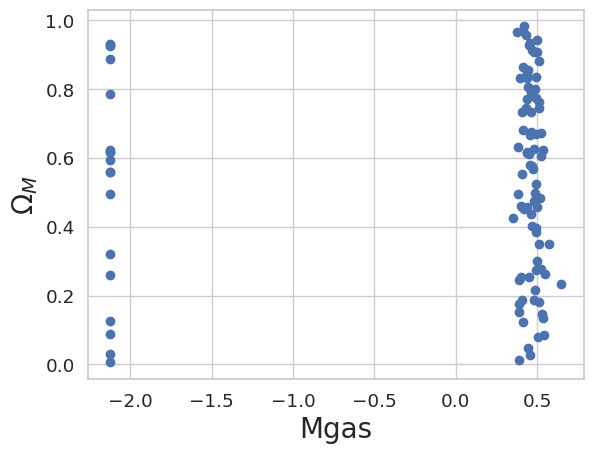

<Figure size 800x600 with 0 Axes>

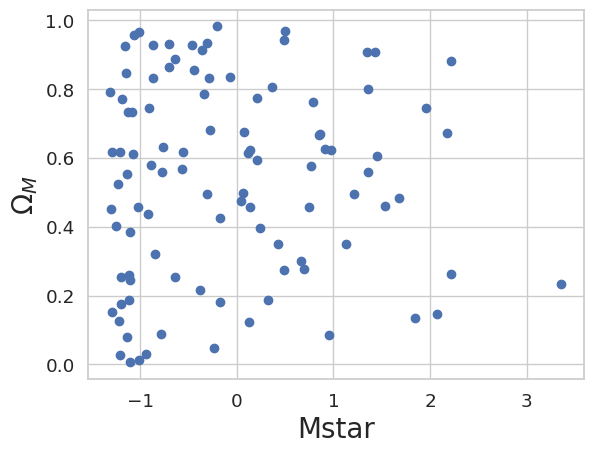

<Figure size 800x600 with 0 Axes>

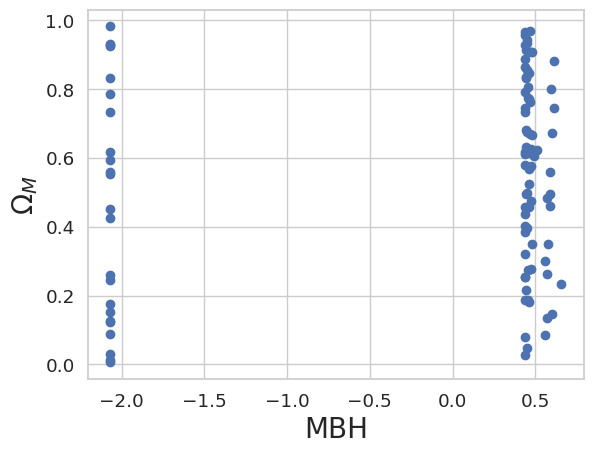

<Figure size 800x600 with 0 Axes>

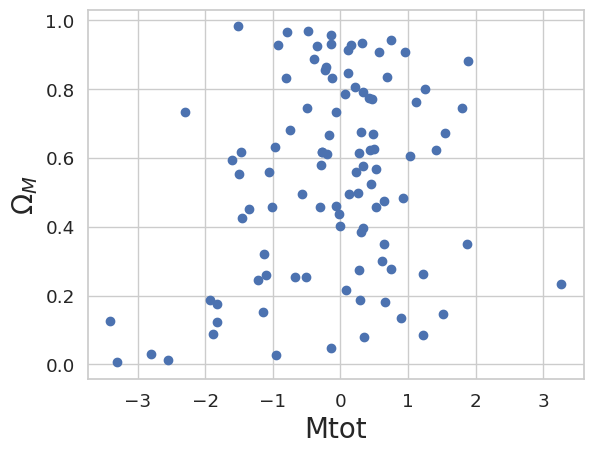

<Figure size 800x600 with 0 Axes>

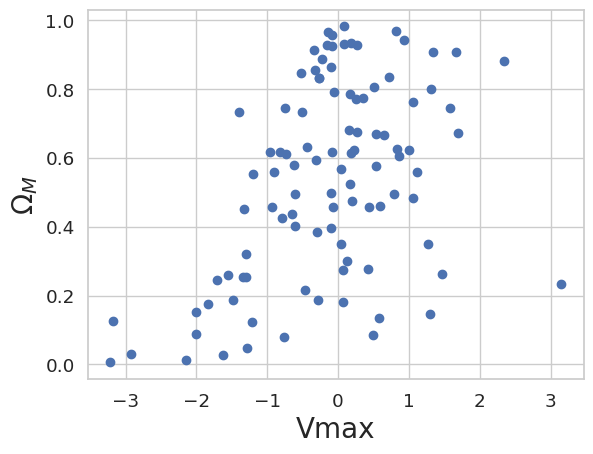

<Figure size 800x600 with 0 Axes>

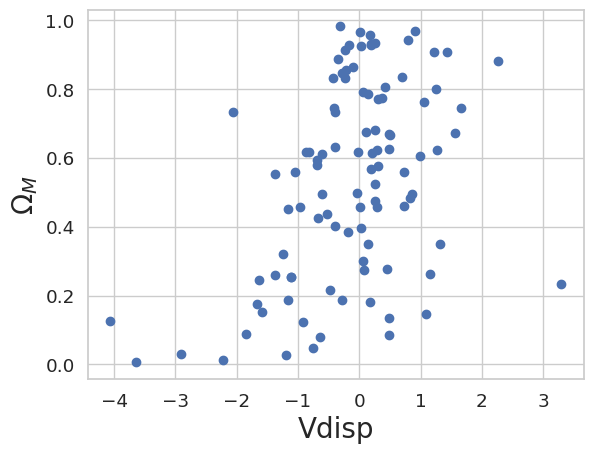

<Figure size 800x600 with 0 Axes>

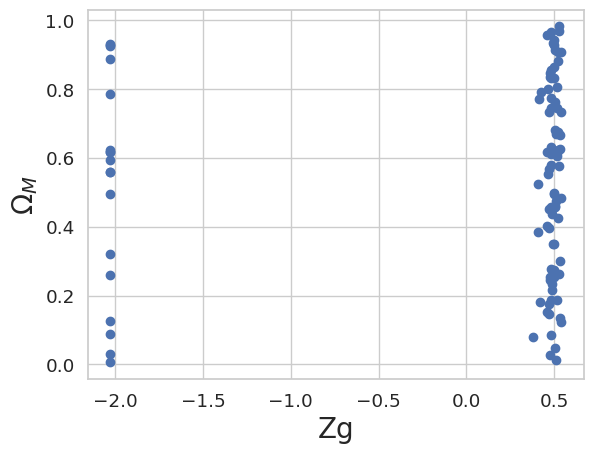

<Figure size 800x600 with 0 Axes>

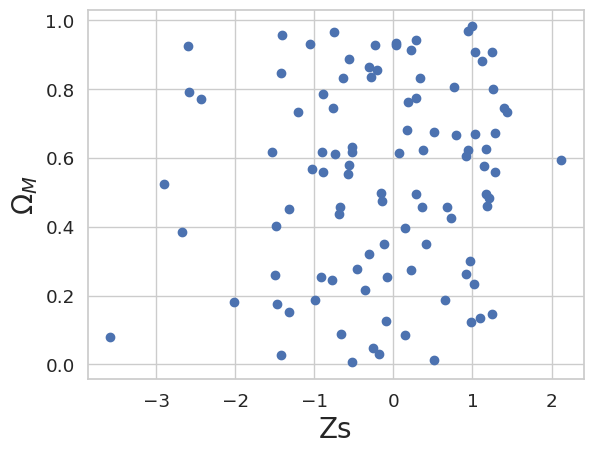

<Figure size 800x600 with 0 Axes>

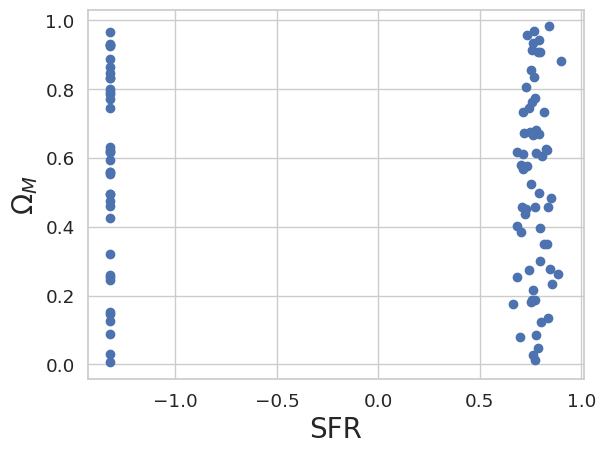

<Figure size 800x600 with 0 Axes>

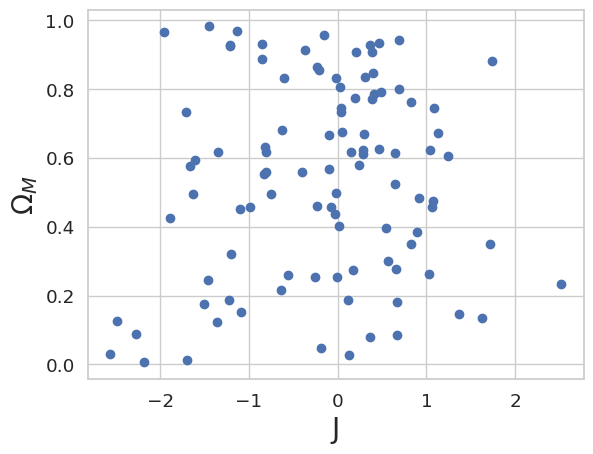

<Figure size 800x600 with 0 Axes>

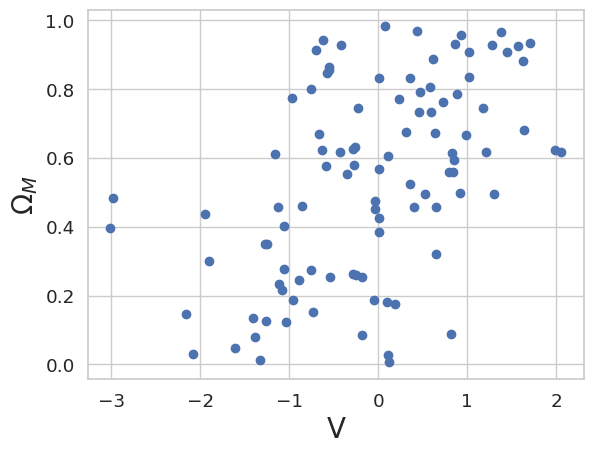

<Figure size 800x600 with 0 Axes>

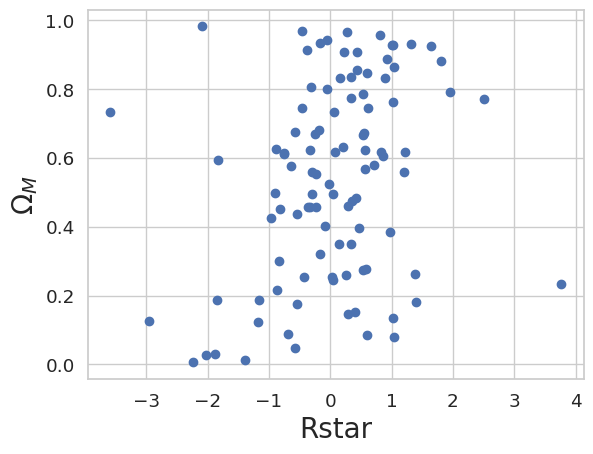

<Figure size 800x600 with 0 Axes>

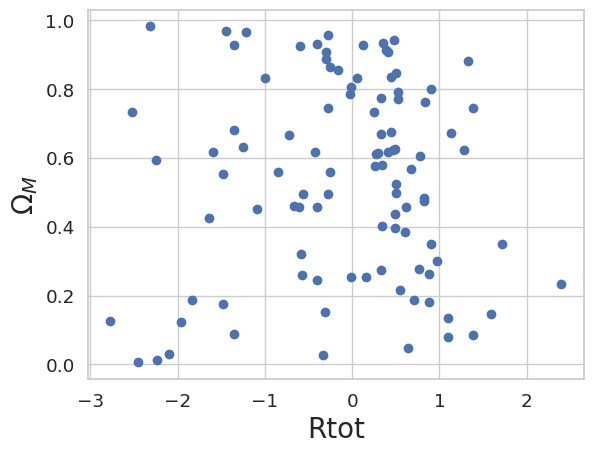

<Figure size 800x600 with 0 Axes>

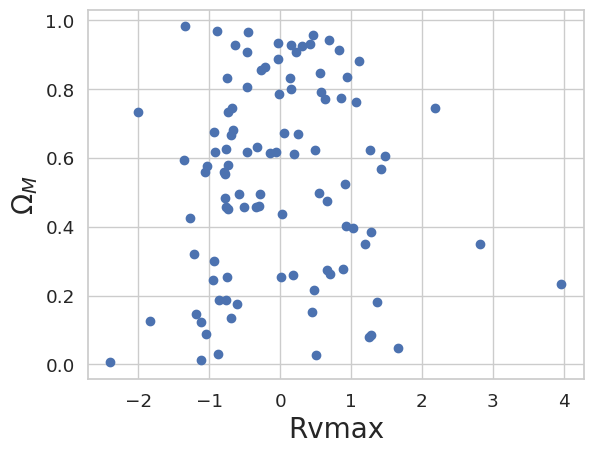

<Figure size 800x600 with 0 Axes>

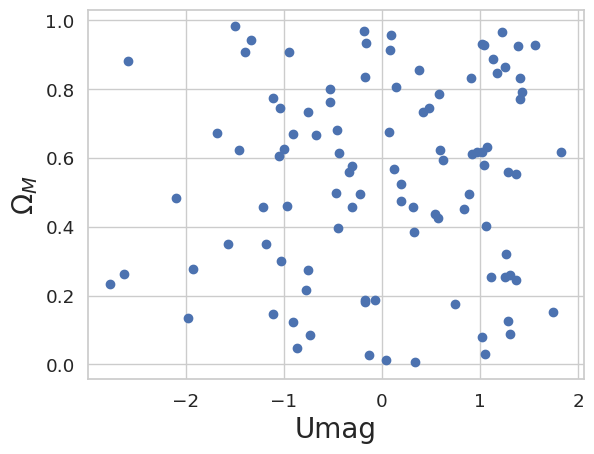

<Figure size 800x600 with 0 Axes>

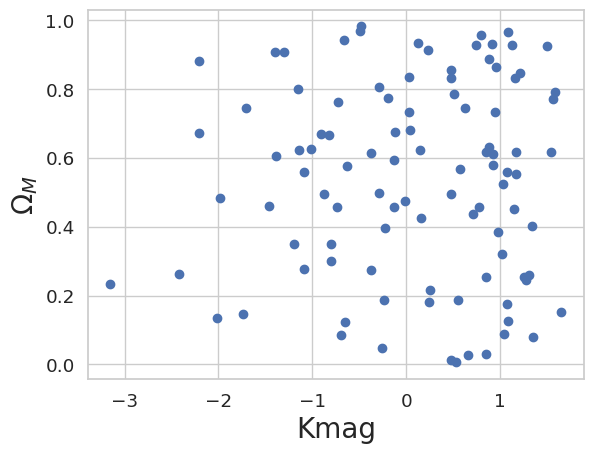

<Figure size 800x600 with 0 Axes>

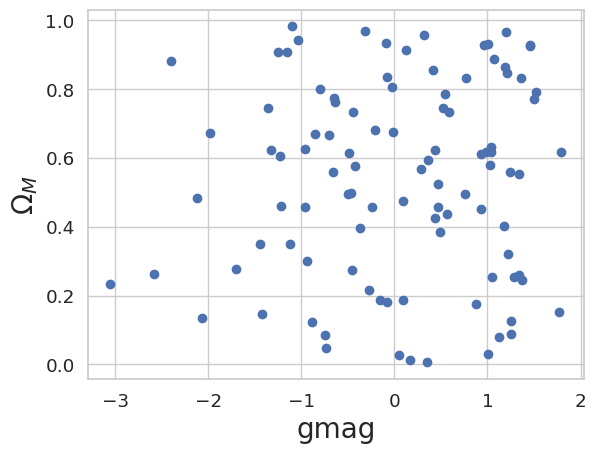

In [ ]:
import seaborn as sns
galprop=["Mgas","Mstar","MBH","Mtot","Vmax","Vdisp","Zg","Zs","SFR","J","V","Rstar","Rtot","Rvmax","Umag","Kmag","gmag"]
cosmo=["$\Omega_M$","$\sigma_8$"]

for galprop_ind,lbl in zip(range(len(galprop)),galprop):

    sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
    plt.figure(figsize=(8, 6))
    plt.figure()
    plt.scatter(X_train[0:100,galprop_ind],theta[0:100,0])
    plt.xlabel(lbl,fontsize=20)
    plt.ylabel(cosmo[0],fontsize=20)

<Figure size 800x600 with 0 Axes>

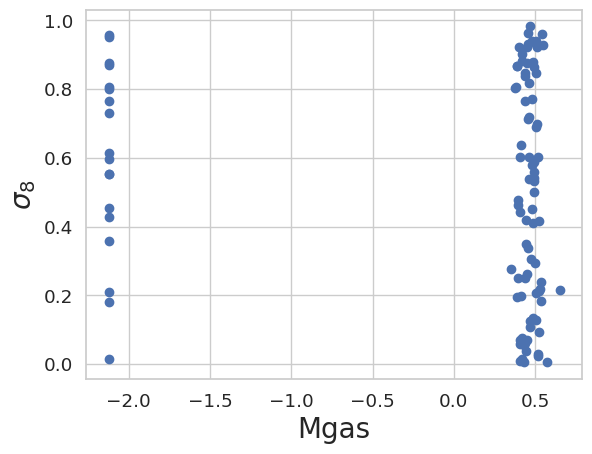

<Figure size 800x600 with 0 Axes>

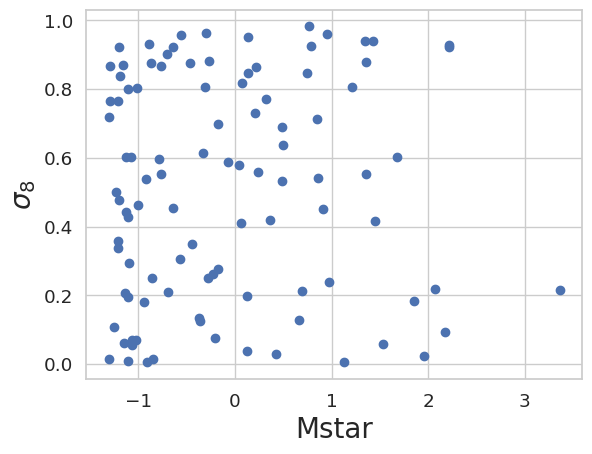

<Figure size 800x600 with 0 Axes>

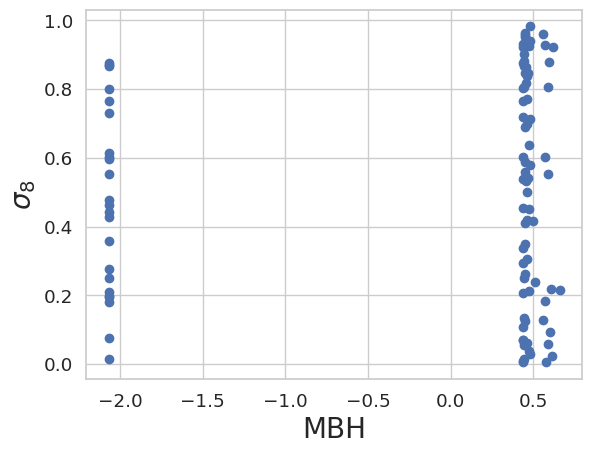

<Figure size 800x600 with 0 Axes>

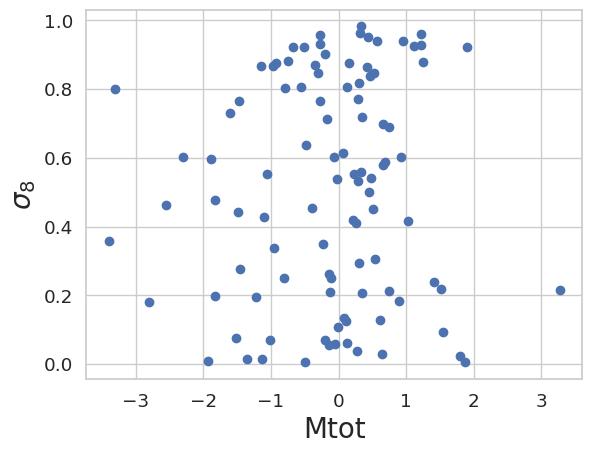

<Figure size 800x600 with 0 Axes>

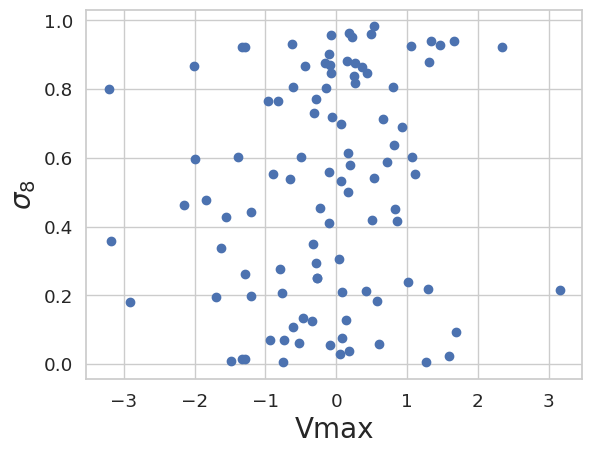

<Figure size 800x600 with 0 Axes>

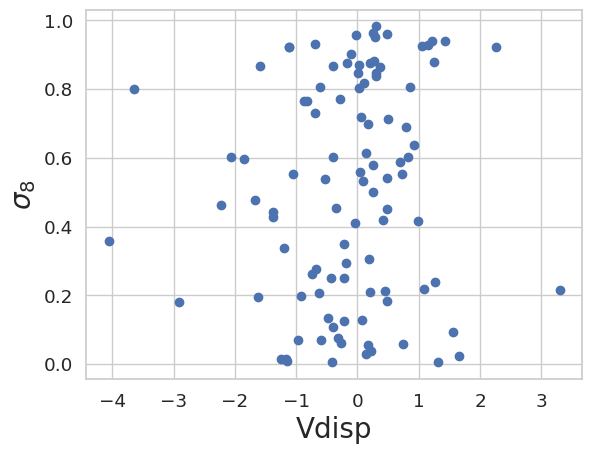

<Figure size 800x600 with 0 Axes>

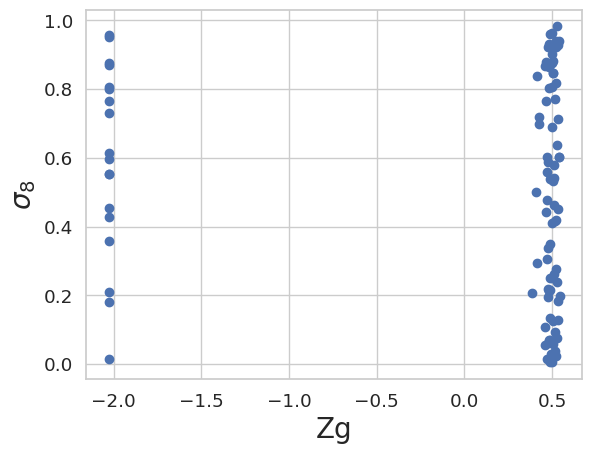

<Figure size 800x600 with 0 Axes>

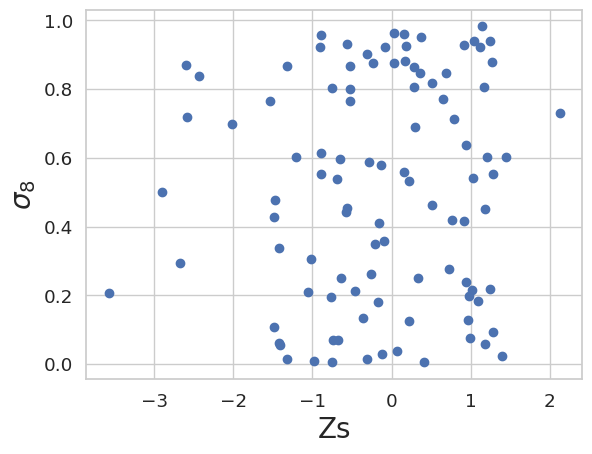

<Figure size 800x600 with 0 Axes>

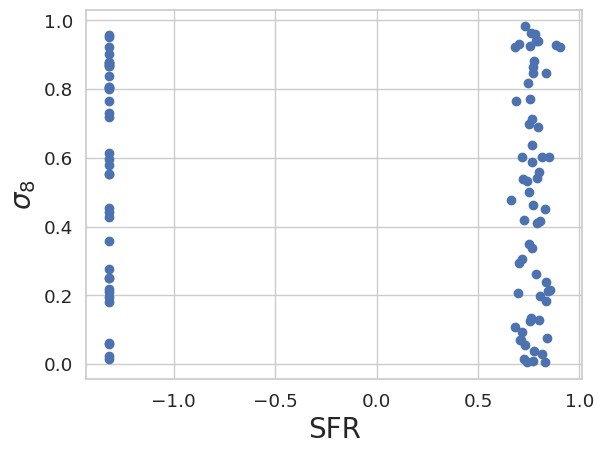

<Figure size 800x600 with 0 Axes>

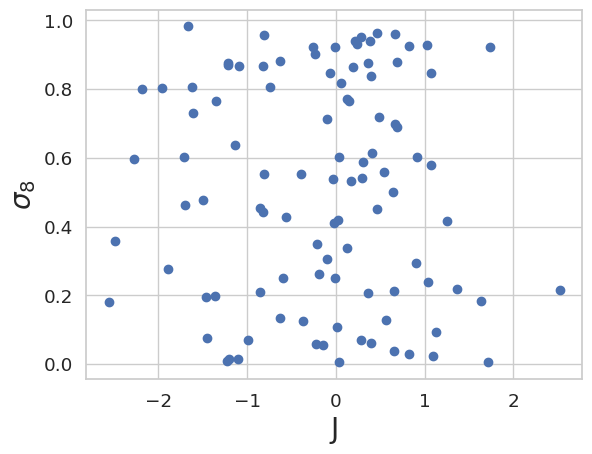

<Figure size 800x600 with 0 Axes>

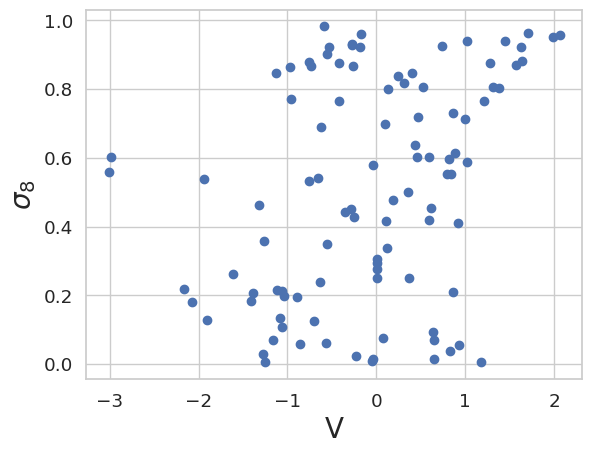

<Figure size 800x600 with 0 Axes>

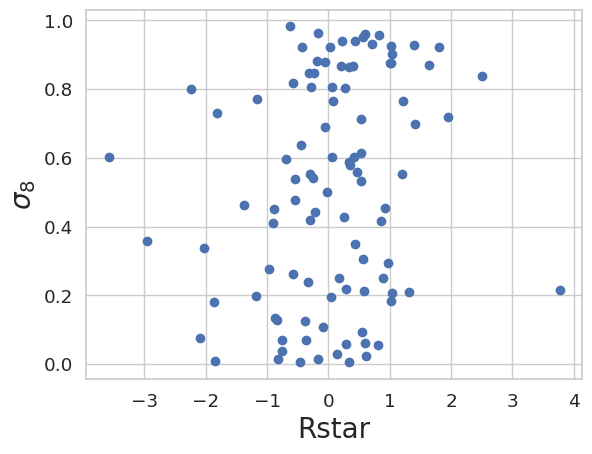

<Figure size 800x600 with 0 Axes>

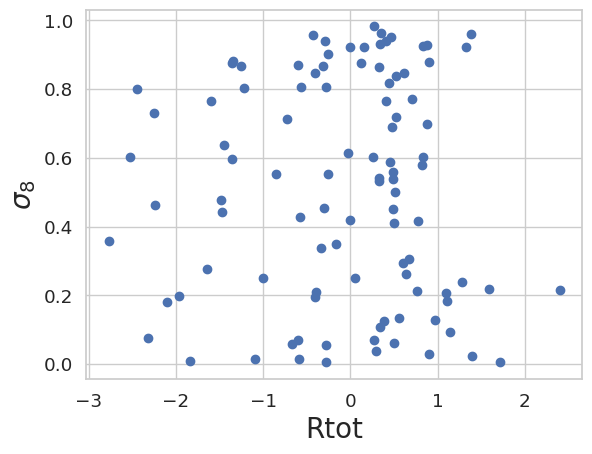

<Figure size 800x600 with 0 Axes>

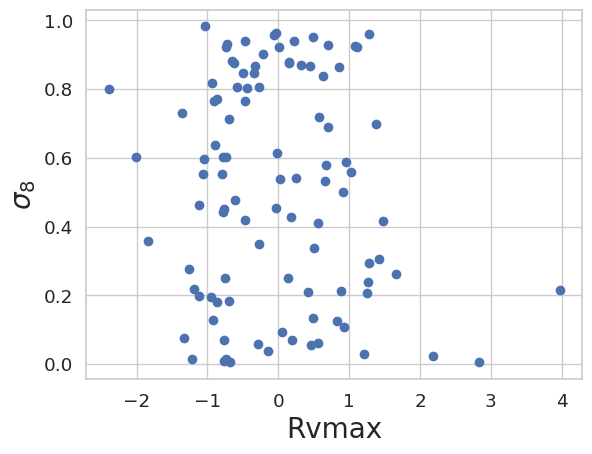

<Figure size 800x600 with 0 Axes>

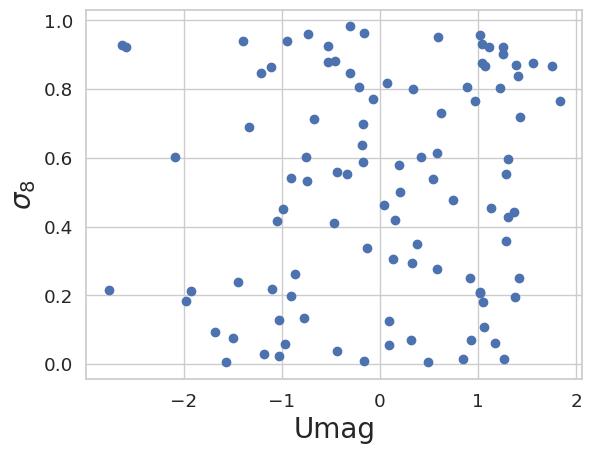

<Figure size 800x600 with 0 Axes>

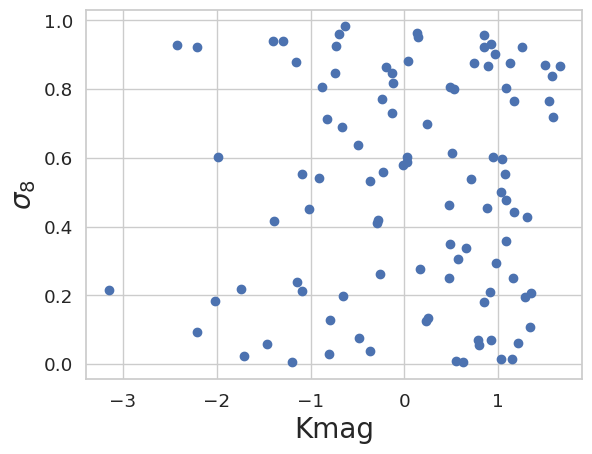

<Figure size 800x600 with 0 Axes>

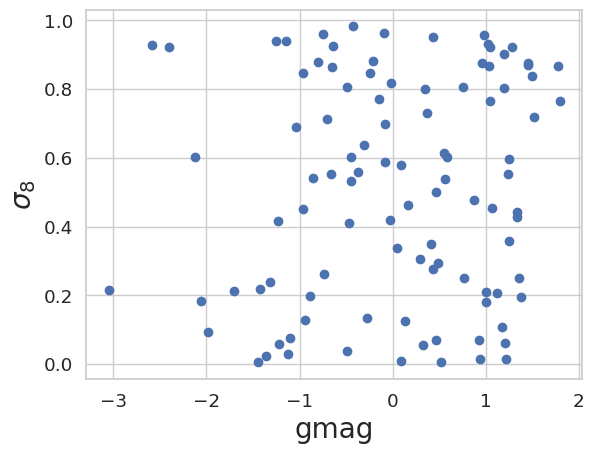

In [ ]:
galprop=["Mgas","Mstar","MBH","Mtot","Vmax","Vdisp","Zg","Zs","SFR","J","V","Rstar","Rtot","Rvmax","Umag","Kmag","gmag"]
cosmo=["$\Omega_M$","$\sigma_8$"]

for galprop_ind,lbl in zip(range(len(galprop)),galprop):

    sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
    plt.figure(figsize=(8, 6))
    plt.figure()
    plt.scatter(X_train[0:100,galprop_ind],theta[0:100,1])
    plt.xlabel(lbl,fontsize=20)
    plt.ylabel(cosmo[1],fontsize=20)

In [ ]:
# define a prior
prior = ili.utils.Uniform(low=[0, 0], high=[1, 1], device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=50, num_transforms=5),
    #ili.utils.load_nde_sbi(engine='NPE', model='mdn', hidden_features=50, num_components=6)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=None,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [ ]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

 Neural network successfully converged after 118 epochs.

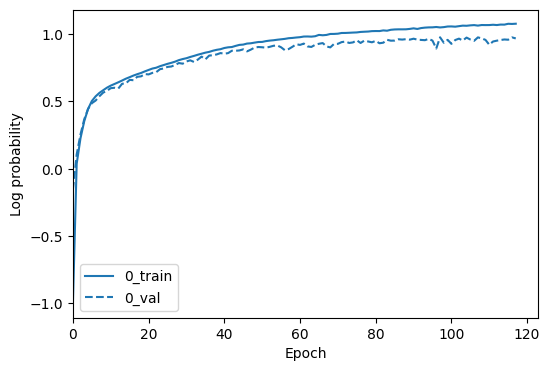

In [ ]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [ ]:
# choose a random input
seed_in = 49
np.random.seed(seed_in)
ind = np.random.randint(len(theta))

# generate samples from the posterior using accept/reject sampling
seed_samp = 32
torch.manual_seed(seed_samp)
samples = posterior_ensemble.sample((1000,), torch.Tensor(X_train[ind]).to(device))

# calculate the log_prob for each sample
log_prob = posterior_ensemble.log_prob(samples, torch.Tensor(X_train[ind]).to(device))

samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

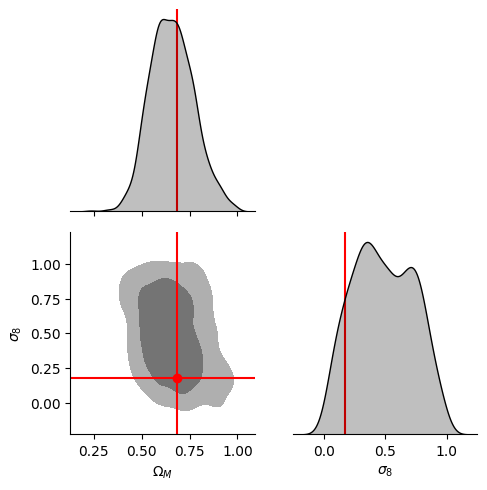

In [ ]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    labels=['$\Omega_M$','$\sigma_8$']
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = X_train[ind], theta_fid=theta[ind],
    plot_kws=dict(fill=True)
)

# Inference with the CAMELS MultiField Dataset (Images of Baryonic Fields)

In [ ]:
# Download CAMELS 2D maps and latin hypercube parameters (~3.2 GB)
import os
os.makedirs('./toy', exist_ok=True)
!curl https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/IllustrisTNG/Maps_T_IllustrisTNG_LH_z=0.00.npy -o ./toy/Maps_T_IllustrisTNG_LH_z=0.00.npy
!curl https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/IllustrisTNG/params_LH_IllustrisTNG.txt -o ./toy/params_LH_IllustrisTNG.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 48000  100 48000    0     0  93472      0 --:--:-- --:--:-- --:--:-- 93385


In [ ]:
# load data
x = np.log10(np.load('/content/toy/Maps_T_IllustrisTNG_LH_z=0.00.npy', allow_pickle=True))
theta = np.loadtxt('/content/toy/params_LH_IllustrisTNG.txt')
theta = np.repeat(theta, 15, axis=0)

# subsample (for speed)
x = x[::2]
theta = theta[::2]

# conform images to pytorch expected shape
x = x[:,None,...]

# make a dataloader
loader = NumpyLoader(x=x, theta=theta)

# determine prior bounds
prior_min = theta.min(axis=0)
prior_max = theta.max(axis=0)

In [ ]:
labels = [r'$\Omega_m$', r'$\sigma_8$', r'$A_{SN1}$',
          r'$A_{AGN1}$', r'$A_{SN2}$', r'$A_{AGN2}$']

# plot a few examples of the data
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    ind = np.random.randint(len(x))
    im = axs[i].imshow(x[ind,0], cmap='RdBu_r')

    title = [f'{labels[j]}={theta[ind,j]:.2f}' for j in range(6)]
    title.insert(3, '\n')
    axs[i].set_title(' '.join(title))
    axs[i].axis('off')

In [ ]:
# let's build a convolutional embedding network for processing images

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=8, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),
            nn.Conv2d(16, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )

    def forward(self, x):
        out = self.conv_layers(x)
        out = out.view(out.size(0), -1)
        out = self.fc_layers(out)
        return out

In [ ]:
# define a prior
prior = ili.utils.Uniform(low=prior_min, high=prior_max, device=device)

# instantiate a CNN embedding network
embedding_net = ConvNet()

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=50, num_transforms=5,
                           embedding_net=embedding_net),
    ili.utils.load_nde_sbi(engine='NPE', model='mdn', hidden_features=50, num_components=6,
                           embedding_net=embedding_net)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 5e-5,
    'stop_after_epochs': 50
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=embedding_net,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [ ]:
# train the model. this outputs a posterior model and training logs
posterior_ensemble, summaries = runner(loader=loader)

In [ ]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [ ]:
# choose a random input
ind = np.random.randint(len(theta))
x_test = torch.Tensor(x[ind]).to(device)

# generate samples from the posterior using accept/reject sampling
samples = posterior_ensemble.sample((1000,), x_test)
# calculate the log_prob for each sample
log_prob = posterior_ensemble.log_prob(samples, x_test)

samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

In [ ]:
# plot the posterior samples and the true value
fig, axs = plt.subplots(1, 3, figsize=(10,4), gridspec_kw={'width_ratios': [1,1,0.05]})
for i in range(2):
    axs[i].plot(theta[ind,i], theta[ind,i+1], 'r+', markersize=10, label='true')
    im = axs[i].scatter(samples[:,i], samples[:,i+1], c=log_prob, s=4, label='samples')
    axs[i].set_xlim(prior_min[i], prior_max[i])
    axs[i].set_ylim(prior_min[i+1], prior_max[i+1])
    axs[i].set_xlabel(labels[i])
    axs[i].set_ylabel(labels[i+1])
    axs[i].legend()
plt.colorbar(im, label='log probability', use_gridspec=True, cax=axs[2])

In [ ]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    labels=labels, out_dir=None
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x[ind], theta_fid=theta[ind],
)